In [2]:
import pandas as pd
import torch
#import torch_geometric 
#import torch_geometric_temporal
import numpy as np

import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt

import networkx as nx
from scipy.spatial.distance import euclidean

import torch
from torch_geometric.data import Data

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

In [23]:
df_flowdata = pd.read_csv(FLOWDATA_PATH, index_col=0)
#print(df_flowdata.head())

df_subsetgraph = pd.read_csv(SUBSETGRAPH_PATH, index_col=0)
#print(df_subsetgraph.head())

In [26]:
# Convert the column to datetime
#df_flowdata[0] = pd.to_datetime(df_flowdata[0])

df_flowdata.index = pd.to_datetime(df_flowdata.index, format='%d-%b-%Y %H:%M:%S')
print(df_flowdata.index)
# Set it as the index
#df_flowdata.set_index('Time', inplace=True)


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:15:00',
               '2020-01-01 00:30:00', '2020-01-01 00:45:00',
               '2020-01-01 01:00:00', '2020-01-01 01:15:00',
               '2020-01-01 01:30:00', '2020-01-01 01:45:00',
               '2020-01-01 02:00:00', '2020-01-01 02:15:00',
               ...
               '2024-09-29 20:30:00', '2024-09-29 20:45:00',
               '2024-09-29 21:00:00', '2024-09-29 21:15:00',
               '2024-09-29 21:30:00', '2024-09-29 21:45:00',
               '2024-09-29 22:00:00', '2024-09-29 22:15:00',
               '2024-09-29 22:30:00', '2024-09-29 22:45:00'],
              dtype='datetime64[ns]', name='Time', length=166460, freq=None)


In [33]:
df_flowdata['hour'] = df_flowdata.index.hour
df_flowdata['dayofweek'] = df_flowdata.index.dayofweek  # Monday=0, Sunday=6
df_flowdata['month'] = df_flowdata.index.month


In [38]:
df_flowdata['strata'] = df_flowdata[['hour', 'dayofweek', 'month']].astype(str).agg('_'.join, axis=1)


In [4]:
# converting data to floats, and missing data to NaN
# this is so geopandas can process it
for column in ['Start_x','Start_y','End_x','End_y']:
    df_subsetgraph[column] = pd.to_numeric(df_subsetgraph[column], errors='coerce')

# create a LineString object for each pipe segment in the dataset
geometry = []
for idx, row in df_subsetgraph.iterrows():
    start_point = (row['Start_x'], row['Start_y'])
    end_point = (row['End_x'], row['End_y'])
    
    line = LineString([start_point, end_point])
    geometry.append(line)


water_network_sensors = gpd.GeoDataFrame(df_subsetgraph, geometry=geometry)

In [5]:
nodes_start = gpd.GeoDataFrame(df_subsetgraph[['NODE1_ID', 'Start_x', 'Start_y']],
                               geometry=[Point(xy) for xy in zip(df_subsetgraph['Start_x'], df_subsetgraph['Start_y'])])

nodes_end = gpd.GeoDataFrame(df_subsetgraph[['NODE2_ID', 'End_x', 'End_y']],
                             geometry=[Point(xy) for xy in zip(df_subsetgraph['End_x'], df_subsetgraph['End_y'])])

nodes = pd.concat([
    nodes_start.rename(columns={'NODE1_ID':'NODE_ID'}),
    nodes_end.rename(columns={'NODE2_ID':'NODE_ID'})
], ignore_index=True)

water_network_nodes = nodes.drop_duplicates(subset='NODE_ID')

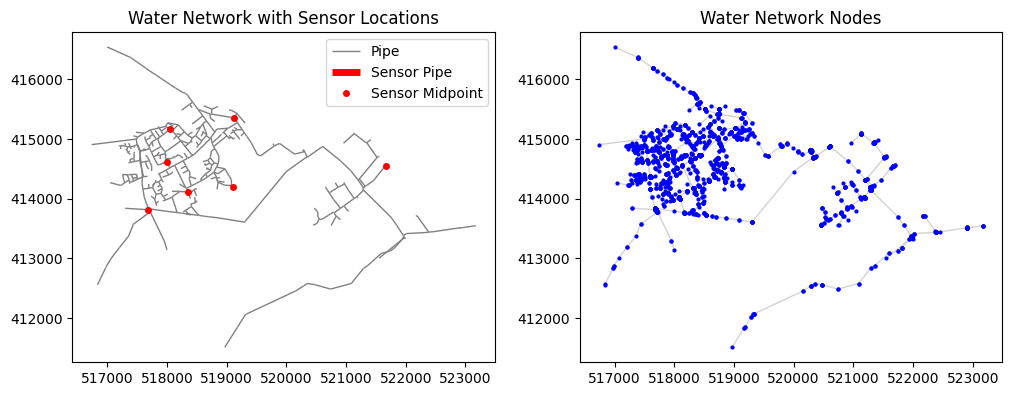

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

water_network_sensors[water_network_sensors['SensorIndicator']==0].plot(ax=ax1, color='gray', linewidth=1, zorder=1)
water_network_sensors[water_network_sensors['SensorIndicator']==1].plot(ax=ax1, color='red', linewidth=5, zorder=2)

for _, row in water_network_sensors[water_network_sensors['SensorIndicator']==1].iterrows():
    mid_x = (row['Start_x'] + row['End_x']) / 2
    mid_y = (row['Start_y'] + row['End_y']) / 2
    ax1.plot(mid_x, mid_y, 'ro', markersize=4, zorder=3)

ax1.set_title("Water Network with Sensor Locations")
ax1.legend(['Pipe','Sensor Pipe','Sensor Midpoint'])


water_network_sensors.plot(ax=ax2, color='lightgray', linewidth=1, zorder=1) 
water_network_nodes.plot(ax=ax2, color='blue', markersize=4, zorder=2)
ax2.set_title("Water Network Nodes")

plt.show()

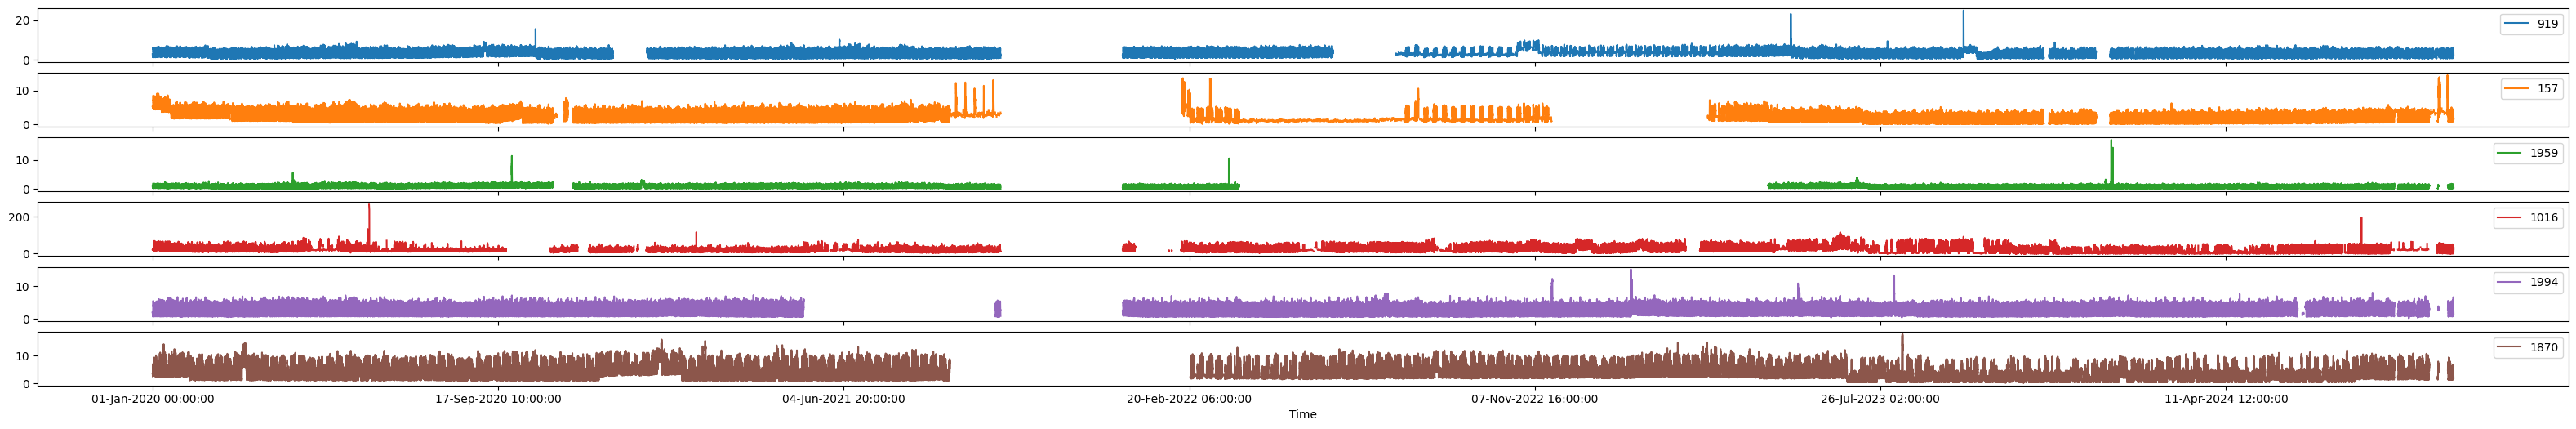

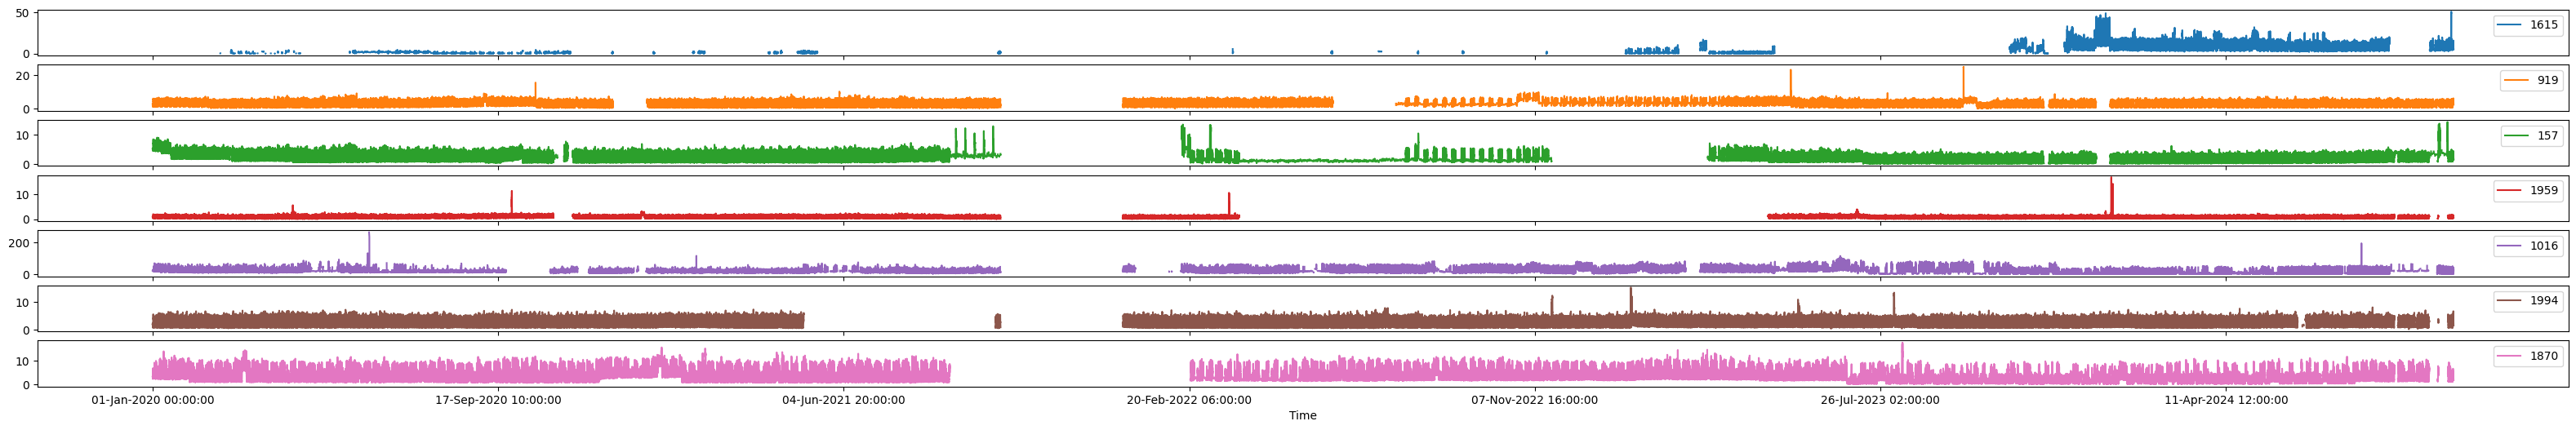

In [ ]:
df_flowdata.plot(
    subplots=True,
    figsize=(40, 6),
    sharex=True
)
plt.show()


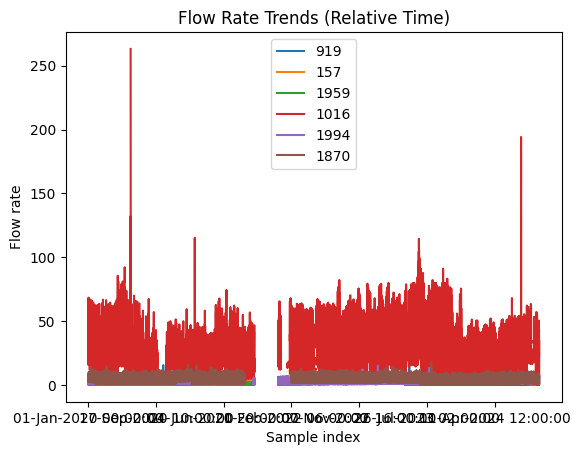

In [12]:
df_flowdata.iloc[:, 1:].plot()
plt.xlabel("Sample index")
plt.ylabel("Flow rate")
plt.title("Flow Rate Trends (Relative Time)")
plt.show()


In [1]:
import matplotlib.pyplot as plt

"""sensor_columns = df_flowdata.columns[1:]

# Take 2000 random rows
df_sample = df_flowdata.sample(n=2000, random_state=42).sort_index()

for sensor in sensor_columns:
    plt.figure()
    plt.plot(df_sample.index, df_sample[sensor])
    plt.xlabel("Row index (time order)")
    plt.ylabel("Flow rate")
    plt.title(f"Flow rate trend – {sensor} (random sample)")
    plt.grid(True)
    plt.show()

"""
df_sample = df_flowdata.sample(n=96).sort_index()


df_sample.plot(
    figsize=(40, 6),
    sharex=True
)
plt.show()


NameError: name 'df_flowdata' is not defined

In [ ]:
df_flowdata['hour'] = df_flowdata.index.hour
df_flowdata['dayofweek'] = df_flowdata.index.dayofweek  # 0=Monday, 6=Sunday
df_flowdata['month'] = df_flowdata.index.month


In [ ]:


# Assuming df_flowdata is already loaded with time column as index or first column
# If time is not the index, set it:
# df_flowdata = df_flowdata.set_index(df_flowdata.columns[0])
# df_flowdata.index = pd.to_datetime(df_flowdata.index)

# 1. Overall Time Series Plot (all sensors)
plt.figure(figsize=(15, 6))
for col in df_flowdata.columns:
    plt.plot(df_flowdata.index, df_flowdata[col], alpha=0.6, label=col)
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.title('All Sensors Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Individual Sensor Plots (select a few sensors)
sensors_to_plot = df_flowdata.columns[:4]  # Adjust number as needed
fig, axes = plt.subplots(len(sensors_to_plot), 1, figsize=(15, 3*len(sensors_to_plot)))
if len(sensors_to_plot) == 1:
    axes = [axes]
    
for ax, sensor in zip(axes, sensors_to_plot):
    ax.plot(df_flowdata.index, df_flowdata[sensor])
    ax.set_ylabel('Flow Rate')
    ax.set_title(f'Sensor: {sensor}')
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

# 3. Heatmap - Daily Pattern (average by hour of day and day of week)
df_temp = df_flowdata.copy()
df_temp['hour'] = df_temp.index.hour
df_temp['day_of_week'] = df_temp.index.dayofweek

# For first sensor as example
sensor = df_flowdata.columns[0]
daily_pattern = df_temp.groupby(['day_of_week', 'hour'])[sensor].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(daily_pattern, cmap='YlOrRd', cbar_kws={'label': 'Flow Rate'})
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday)')
plt.title(f'Daily Pattern Heatmap - {sensor}')
plt.tight_layout()
plt.show()

# 4. Seasonal Decomposition (for one sensor)


sensor = df_flowdata.columns[0]
# Resample to daily for clearer seasonal patterns
daily_data = df_flowdata[sensor].resample('D').mean()

decomposition = seasonal_decompose(daily_data.dropna(), model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.suptitle(f'Seasonal Decomposition - {sensor}')
plt.tight_layout()
plt.show()

# 5. Monthly Averages
df_temp['month'] = df_temp.index.month
df_temp['year'] = df_temp.index.year

monthly_avg = df_temp.groupby(['year', 'month'])[df_flowdata.columns[0]].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

plt.figure(figsize=(15, 6))
plt.plot(monthly_avg['date'], monthly_avg[df_flowdata.columns[0]], marker='o')
plt.xlabel('Month')
plt.ylabel('Average Flow Rate')
plt.title(f'Monthly Average Flow Rate - {df_flowdata.columns[0]}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Box Plot by Month (showing seasonal variation)
df_temp['month_name'] = df_temp.index.strftime('%b')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(15, 6))
df_temp.boxplot(column=df_flowdata.columns[0], by='month_name', ax=plt.gca())
plt.xticks(range(1, 13), month_order)
plt.xlabel('Month')
plt.ylabel('Flow Rate')
plt.title(f'Monthly Flow Rate Distribution - {df_flowdata.columns[0]}')
plt.suptitle('')
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap between sensors
plt.figure(figsize=(10, 8))
correlation_matrix = df_flowdata.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Sensor Correlation Matrix')
plt.tight_layout()
plt.show()

# 8. Weekday vs Weekend Comparison
df_temp['is_weekend'] = df_temp['day_of_week'].isin([5, 6])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for sensor in df_flowdata.columns[:2]:  # First 2 sensors
    weekday_data = df_temp[~df_temp['is_weekend']].groupby('hour')[sensor].mean()
    weekend_data = df_temp[df_temp['is_weekend']].groupby('hour')[sensor].mean()
    
    axes[0].plot(weekday_data.index, weekday_data.values, label=f'{sensor} - Weekday')
    axes[1].plot(weekend_data.index, weekend_data.values, label=f'{sensor} - Weekend')

axes[0].set_title('Average Weekday Pattern')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Flow Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Average Weekend Pattern')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Flow Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
# 1. Overall Time Series Plot (all sensors)
plt.figure(figsize=(15, 6))
for col in df_flowdata.columns:
    plt.plot(df_flowdata.index, df_flowdata[col], alpha=0.6, label=col)
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.title('All Sensors Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


subplots=True,

KeyboardInterrupt: 

In [8]:
df_flowdata['hour'] = df_flowdata.index.hour
df_flowdata['dayofweek'] = df_flowdata.index.dayofweek  # Monday=0, Sunday=6
df_flowdata['month'] = df_flowdata.index.month

AttributeError: 'Index' object has no attribute 'hour'